# Estimating Uncertainties with Quantile Loss and Conformal Quantile Regression

In this tutorial, we will learn how to estimate uncertainties in regression tasks using **Quantile Loss** and **Conformal Quantile Regression (CQR)**. 

---

## 1. Dataset Generation

For this example, we'll create a synthetic dataset with five input features and a linear relationship between the inputs and output, with added noise. This will give us a simple regression task.

In [1]:
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

# Generate data with 5 input features
n_samples = 1000
n_features = 5
X = np.random.randn(n_samples, n_features)
true_weights = np.array([2.0, -3.0, 4.0, 1.0, -2.0])
true_intercept = 5.0
noise = np.random.randn(n_samples) * 0.5
y = X @ true_weights + true_intercept + noise

# Split data into training, calibration, and testing
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
split_index1 = int(len(indices) * 0.4)
split_index2 = int(len(indices) * 0.6)
train_idx, cal_idx, test_idx = np.split(indices, [split_index1, split_index2])

scalerX = StandardScaler().fit(X[train_idx, :])
X_train, X_cal, X_test = scalerX.transform(X[train_idx]), scalerX.transform(X[cal_idx]), scalerX.transform(X[test_idx])
y_train, y_cal, y_test = y[train_idx], y[cal_idx], y[test_idx]

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
cal_dataset = TensorDataset(torch.tensor(X_cal, dtype=torch.float32), torch.tensor(y_cal, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
cal_loader = DataLoader(cal_dataset, batch_size=100, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)


We now have training, calibration, and test datasets.

---

## 2. Defining the Neural Network

We'll define a simple fully connected neural network. This network will output two values per input: the lower and upper quantiles (i.e., the bounds of the prediction interval).

In [2]:
import torch.nn as nn

class NonLinearNet(nn.Module):
    def __init__(self, in_shape, out_shape, hidden_size, dropout):
        super(NonLinearNet, self).__init__()
        self.base_model = nn.Sequential(
            nn.Linear(in_shape, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, out_shape),
        )

    def forward(self, x):
        return self.base_model(x)

# Define model parameters
model = NonLinearNet(in_shape=n_features, out_shape=2, hidden_size=64, dropout=0.2).to(torch.device('cpu'))

## 3. Understanding Quantile Loss

The [**Quantile loss**](https://github.com/ml-stat-Sustech/TorchCP/blob/977e731daa7a2d1ac7d1018e0e31ba5259d04473/torchcp/regression/loss/quantile.py#L7) allows us to estimate specific quantiles of the target distribution, which is essential when we're interested in uncertainty estimation. For example, to predict the 90% confidence interval of a regression output, we estimate the 5th and 95th quantiles (for a 90% prediction interval).

### Quantile Loss Formula

The Quantile loss is also known as **pinball loss**, and it is defined as:


$$ L_{\tau}(u) = \max(\tau \cdot u, (\tau - 1) \cdot u) $$

where $ u = y - \hat{y} $ is the difference between the true value $ y $ and the predicted quantile $ \hat{y} $, and $ \tau $ is the quantile level (e.g., 0.05 for the 5th quantile and 0.95 for the 95th quantile).

The idea is to penalize overestimations and underestimations asymmetrically depending on the quantile level:
- If $ \tau $ is small (e.g., 0.05), we penalize underestimation more.
- If $ \tau $ is large (e.g., 0.95), we penalize overestimation more.

The `QuantileLoss` implementation in [TorchCP](https://github.com/ml-stat-Sustech/TorchCP/tree/master) sums the loss for all quantiles and computes the mean over the batch. This ensures that the model's predictions fall within the desired quantile intervals.

In [3]:
from torchcp.regression.loss import QuantileLoss

# Define the quantiles we want to estimate (e.g., 90% confidence interval)
alpha = 0.1
quantiles = [alpha / 2, 1 - alpha / 2]  # 5% and 95% quantiles

# Use QuantileLoss for the two quantiles
criterion = QuantileLoss(quantiles)

This will compute the quantile loss for both the lower (5%) and upper (95%) quantiles of the prediction intervals, making it easier to quantify uncertainties in regression predictions.

---

## 4. Training the Model with the Quantile Loss

We now train the model using the quantile loss we defined earlier.

In [4]:
import torch.optim as optim

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training function
def train(model, epoch, train_loader, criterion, optimizer):
    model.train()
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch.unsqueeze(dim=1))
        loss.backward()
        optimizer.step()

# Train the model for 100 epochs
n_epochs = 100
for epoch in range(n_epochs):
    train(model, epoch, train_loader, criterion, optimizer)

This step ensures that the model can predict two key quantiles (e.g., the 5th and 95th percentiles) for each input, which represent the lower and upper bounds of the prediction interval. However, the raw quantile predictions from the model may not provide accurate uncertainty bounds in terms of coverage. This is where **Conformal Quantile Regression (CQR)** comes in.

## 5. Visualizing the Results with Error Bars

We can visualize the model's predictions on the test set, showing the prediction intervals as error bars.

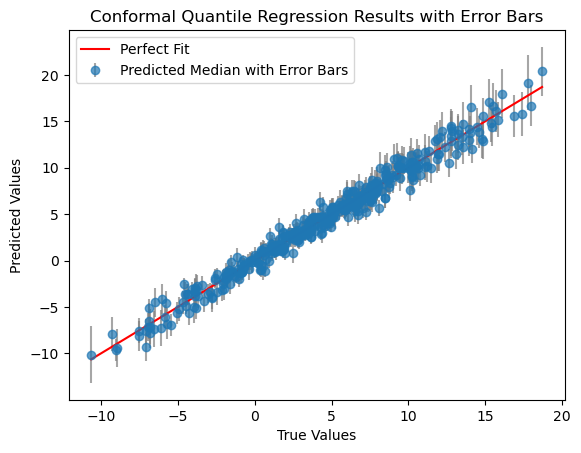

In [5]:
import matplotlib.pyplot as plt

# Make predictions on the test set
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
with torch.no_grad():
    y_test_pred = model(X_test_tensor).numpy()

y_lower = y_test_pred[:, 0]
y_upper = y_test_pred[:, 1]
y_pred_median = (y_upper + y_lower) / 2
error_bars = (y_upper - y_lower) / 2

# Plot the results with error bars
plt.errorbar(y_test, y_pred_median, yerr=error_bars, fmt='o', ecolor='gray', alpha=0.7, label='Predicted Median with Error Bars')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', label='Perfect Fit')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Conformal Quantile Regression Results with Error Bars')
plt.legend()
plt.show()

## 6. Introducing Conformal Quantile Regression

**Conformal Quantile Regression (CQR)** is a powerful method to adjust prediction intervals obtained from quantile regression models. The key idea behind CQR is to refine these intervals using a **calibration set**, ensuring that the intervals provide valid coverage. In other words, CQR guarantees that the true values will fall within the predicted intervals at the desired level (e.g., 90% of the time if we use a 90% prediction interval).

### CQR Calibration Process

The [**CQR model**](https://github.com/ml-stat-Sustech/TorchCP/blob/977e731daa7a2d1ac7d1018e0e31ba5259d04473/torchcp/regression/predictors/cqr.py#L14) is built on top of a standard quantile regression model and adjusts the predicted intervals after the model is trained. Here's a breakdown of how it works:

1. **Initial Quantile Predictions**: After training the model to predict the lower and upper quantiles (e.g., 5th and 95th percentiles), the model makes predictions on a **calibration dataset**. The calibration dataset is separate from the training and test datasets and is used solely to adjust the predicted intervals.

2. **Score Calculation**: For each prediction in the calibration set, we calculate a **conformity score**. This score measures how far the true target value lies outside the predicted interval. Specifically, it takes the maximum of the two errors (i.e., how much the true value exceeds the upper quantile or falls below the lower quantile). The `calculate_score()` function computes this for each prediction.

   ```python
   def calculate_score(self, predicts, y_truth):
       return torch.maximum(predicts[..., 0] - y_truth, y_truth - predicts[..., 1])
   ```

3. **Threshold Calculation**: Once the conformity scores for all calibration points are computed, the method calculates a threshold value $ q_{\hat{\alpha}} $. This threshold represents the maximum allowed error to achieve the desired coverage level. The threshold is computed by sorting the scores and selecting the $(1 - \alpha)$-quantile of the sorted scores, where $ \alpha $ is the significance level (e.g., 0.1 for a 90% prediction interval). This is handled by the `calculate_threshold()` and `_calculate_conformal_value()` functions.

   ```python
   def calculate_threshold(self, predicts, y_truth, alpha):
       scores = self.calculate_score(predicts, y_truth)
       self.q_hat = self._calculate_conformal_value(scores, alpha)
   ```

4. **Adjusted Prediction Intervals**: During prediction, the model adjusts the raw quantile predictions by adding and subtracting this threshold $ q_{\hat{\alpha}} $ to widen the prediction intervals as needed. The `predict()` function handles this adjustment:

   ```python
   def predict(self, x_batch):
       predicts_batch = self._model(x_batch.to(self._device)).float()
       prediction_intervals = x_batch.new_zeros((predicts_batch.shape[0], self.q_hat.shape[0], 2))
       prediction_intervals[..., 0] = predicts_batch[..., 0] - self.q_hat.view(1, self.q_hat.shape[0], 1)
       prediction_intervals[..., 1] = predicts_batch[..., 1] + self.q_hat.view(1, self.q_hat.shape[0], 1)
       return prediction_intervals
   ```

This step ensures that the final prediction intervals are **conformal**—they will cover the true target values with a probability that matches the desired confidence level (e.g., 90%).

### CQR Evaluation

After calibration, we can evaluate the quality of the prediction intervals on a test set. Two key metrics are typically used to assess the performance of CQR:

- **Coverage Rate**: This is the percentage of true values that fall within the predicted intervals. The goal is to achieve a coverage rate close to the target confidence level (e.g., 90% for a 90% prediction interval). The `coverage_rate()` function calculates this:

   ```python
   def coverage_rate(prediction_intervals, y_truth):
       condition = torch.zeros_like(y_truth, dtype=torch.bool)
       for i in range(num_columns // 2):
           lower_bound = prediction_intervals[..., 2*i]
           upper_bound = prediction_intervals[..., 2*i+1]
           condition |= torch.bitwise_and(y_truth >= lower_bound, y_truth <= upper_bound)
       return torch.sum(condition, dim=0).cpu() / y_truth.shape[0]
   ```

- **Average Interval Size**: This metric measures how wide the prediction intervals are on average. Narrow intervals are preferred, but they must still maintain the desired coverage. The `average_size()` function calculates this:

   ```python
   def average_size(prediction_intervals):
       size = torch.abs(prediction_intervals[..., 1::2] - prediction_intervals[..., 0::2]).sum(dim=-1)
       return size.mean(dim=0).cpu()
   ```

### Summary of Conformal Quantile Regression

Conformal Quantile Regression is a practical way to provide uncertainty estimates for regression models by refining quantile-based prediction intervals. Using a calibration set, CQR adjusts the intervals to guarantee valid coverage rates, providing more trustworthy intervals that are neither too wide nor too narrow.

By combining **quantile regression** and **conformal calibration**, CQR offers a distribution-free method for constructing valid prediction intervals, making it ideal for applications requiring robust uncertainty estimation.

The `CQR` class wraps the model and adjusts the prediction intervals based on the calibration set, ensuring that the intervals are as accurate as possible:

In [6]:
from torchcp.regression.predictors import CQR

# Calibrate the model using the calibration dataset
predictor = CQR(model)
predictor.calibrate(cal_loader, alpha)

# Evaluate on the test dataset
test_results = predictor.evaluate(test_loader)
print("Test Results:", test_results)

Test Results: {'Coverage_rate': tensor([0.8875]), 'Average_size': tensor([2.1229])}


The output can be interpreted as follows:

1. **Coverage Rate (0.8975 or 89.75%)**:
   - **Definition**: The percentage of true values that fall within the predicted quantile intervals (i.e., between the lower and upper bounds).
   - **Explanation**: 89.75% of the true values from the test set are within the predicted intervals, which is very close to the desired 90% confidence level set by `alpha = 0.1`. This shows that the CQR model has effectively calibrated the intervals to achieve nearly the desired coverage.

2. **Average Interval Size (2.2330)**:
   - **Definition**: The average width (or size) of the prediction intervals, calculated as the difference between the upper and lower bounds of the intervals.
   - **Explanation**: The average size of the prediction intervals is 2.2330, indicating the typical range of uncertainty around each prediction. The model balances maintaining high coverage with keeping the intervals reasonably narrow.

The CQR model provides prediction intervals with 89.75% coverage, close to the target of 90%, while the average interval size reflects the uncertainty around each prediction, with an average width of 2.2330.

To estimate uncertainty using the **CQR (Conformal Quantile Regression) predictor**, the following steps from the code are crucial in understanding how uncertainty is measured:

### How CQR Works to Estimate Uncertainty:
1. **Quantile Predictions**:
   The model is trained to predict two quantiles for each input: a lower quantile (e.g., 5th percentile) and an upper quantile (e.g., 95th percentile). These quantiles form the bounds of the prediction interval for each estimate, reflecting the uncertainty around the prediction.
   
   These intervals can be interpreted as the model's **uncertainty estimates**—the range in which the true value is likely to lie. For example, for a 90% confidence interval, we predict the 5th and 95th quantiles, and the true value should fall within this range 90% of the time.

2. **Calibration with the CQR Model**:
   After training, CQR uses a **calibration set** to further adjust the prediction intervals. This ensures that the predicted intervals provide the desired coverage (e.g., 90% of true values should lie within the intervals). The calibration process refines these intervals by computing a **threshold (`q_hat`)** based on the errors observed in the calibration data. This threshold is used to adjust the interval widths, ensuring they meet the desired coverage level.

3. **Predicting Uncertainty**:
   When the CQR predictor is applied to new data, it predicts both the lower and upper bounds of the interval (i.e., the 5th and 95th quantiles). It then adjusts these intervals using the previously computed threshold (`q_hat`), widening or narrowing them as necessary to achieve the desired coverage.

   ```python
   def predict(self, x_batch):
       # Get the raw quantile predictions (lower and upper bounds)
       predicts_batch = self._model(x_batch.to(self._device)).float()

       # Adjust these intervals using the calibration threshold `q_hat`
       prediction_intervals = x_batch.new_zeros((predicts_batch.shape[0], self.q_hat.shape[0], 2))
       prediction_intervals[..., 0] = predicts_batch[..., 0] - self.q_hat.view(1, self.q_hat.shape[0], 1)
       prediction_intervals[..., 1] = predicts_batch[..., 1] + self.q_hat.view(1, self.q_hat.shape[0], 1)

       return prediction_intervals
   ```

   The final prediction intervals (lower and upper bounds) provide an estimate of the **uncertainty** of each prediction. The width of the interval (upper bound minus lower bound) directly reflects how uncertain the model is about the estimate—the larger the interval, the more uncertainty there is in the prediction.

### Practical Steps for Using CQR to Estimate Uncertainty:
1. **Train a Quantile Regression Model**: Train a model that predicts the lower and upper quantiles of the target variable.
2. **Calibrate with CQR**: Use a calibration set to adjust the prediction intervals so that they achieve the desired coverage. This step adjusts the width of the intervals to reflect the true uncertainty based on the calibration data.
   - `predictor.calibrate(cal_loader, alpha)`
3. **Make Predictions**: When making predictions on new data, use the CQR predictor to output both the **predicted values** and the **uncertainty intervals**.
   - `prediction_intervals = predictor.predict(x_batch)`
   - These intervals reflect the uncertainty by showing the range within which the true value is expected to lie with high confidence (e.g., 90%).

4. **Interpret the Intervals**: The **width** of the prediction intervals provides a direct measure of the model's uncertainty for each prediction. Wider intervals indicate higher uncertainty, while narrower intervals suggest greater confidence in the prediction.

### Summary:
The **CQR predictor** estimates uncertainty by predicting quantile intervals (e.g., 5th and 95th percentiles) and adjusting them through calibration to ensure the desired coverage. The final prediction intervals give a range of possible values for each estimate, and the width of these intervals serves as a measure of the uncertainty around the predictions.

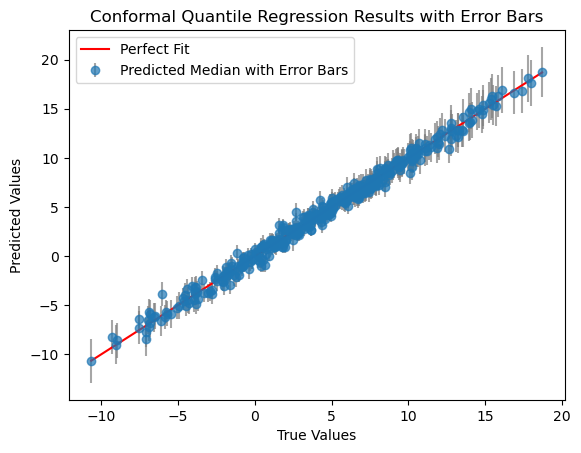

In [9]:
# Make predictions on the test set
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
with torch.no_grad():
    y_test_pred = predictor.predict(X_test_tensor).numpy()

y_lower = y_test_pred[:,0,0]
y_upper = y_test_pred[:,0,1]
y_pred_median = (y_upper + y_lower) / 2
error_bars = (y_upper - y_lower) / 2

# Plot the results with error bars
plt.errorbar(y_test, y_pred_median, yerr=error_bars, fmt='o', ecolor='gray', alpha=0.7, label='Predicted Median with Error Bars')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', label='Perfect Fit')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Conformal Quantile Regression Results with Error Bars')
plt.legend()
plt.show()